In [11]:
import numpy as np
from scipy import sparse
import osqp
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt

In [12]:
def convert_to_fp(mat, man_bits):
    """Function that returns the exponent, mantissa representation for
    floating point numbers that need to be represented on Loihi. A global exp
    is calculated for the matrices based on the max absolute value in the
    matrix. This is then used to calculate the manstissae in the matrix.

    Args:
        mat (np.float): The input floating point matrix that needs to be
        converted
        man_bits (int): number of bits that the mantissa uses for it's
        representation (Including sign)

    Returns:
        mat_fp_man (np.int): The matrix in
    """
    exp = np.ceil(np.log2(np.max(np.abs(mat)))) - man_bits + 1
    mat_fp_man = (mat // 2**exp).astype(int)
    return mat_fp_man.astype(int), exp.astype(int)

In [13]:
def ruiz_equilibriation(matrix, iterations):
    """Preconditioning routine used to make the first-order QP solver converge
    faster. Returns preconditioners to be used to operate on matrices of the QP.

    Args:
        matrix (np.float): Matrix that needs to be preconditioned
        iterations (int): Number of iterations that preconditioner runs for

    Returns:
        left_preconditioner (np.float): The left preconditioning matrix
        right_preconditioner (np.float): The right preconditioning matrix

    """
    m_bar = matrix
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    for _ in range(iterations):
        D_l_inv = sparse.csc_matrix(
            np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1)))
        )
        if m_bar.shape[0] != m_bar.shape[1]:
            D_r_inv = sparse.csc_matrix(
                np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0)))
            )
        else:
            D_r_inv = D_l_inv

        m_bar = D_l_inv @ m_bar @ D_r_inv
        left_preconditioner = left_preconditioner @ D_l_inv
    return left_preconditioner, right_preconditioner

In [14]:
# problem_file = "NeuRIPS_data/anymal_quadruped/01_anymal_small_scale/mpc_240_0800.npz"
path_prefix = "NeuRIPS_data/anymal_quadruped/"
size_indices = list(range(1, 6))
dir_prefixes = ['0' + str(idx) for idx in size_indices]
size_qualitv = ['small', 'medium', 'medium_large', 'full', 'extra_full']
prefix_szql = list(zip(dir_prefixes, size_qualitv))
dir_names = [path_prefix + prefix + '_anymal_' + szql + '_scale/' for (prefix, szql) in prefix_szql]
size_quantiv = [240, 2400, 3600, 4800, 7200]
file_name_prefixes = ['mpc_' + str(szqn) + '_' for szqn in size_quantiv]
dir_file_pfx = list(zip(dir_names, file_name_prefixes))
file_path_pfx = [dn + fnp for (dn, fnp) in dir_file_pfx]
problem_ids = ['0150', '0300', '0500', '0700', '0800', '0900', '1200', '1500', '1800', '2000']
file_names = [fppfx + pid + '.npz' for fppfx in file_path_pfx for pid in problem_ids]

In [15]:
costs = np.zeros((149, 5))
constraint_sats = np.zeros((149, 5))
osqp_costs = np.zeros((5,))
final_state_x_norms = np.zeros((5,))
for idx, filename in enumerate(file_names[1:50:10]):

    # Parameters: Reset alpha and beta
    alpha_man = 160
    alpha_exp = -8

    beta_man = 7
    beta_exp = -10

    alpha_decay_indices_list = (
        np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]) * 2
    )
    beta_growth_indices_list = (
        np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2045, 4095]) * 2 + 1
    )

    # Load problem matrices
    matrices = np.load(filename)
    Q, A, p, k = [matrices[i] for i in matrices]
    k = k.reshape(k.shape[0], )
    p = p.reshape(p.shape[0], )

    # Precondition
    (pre_mat_Q, _) = ruiz_equilibriation(Q, 5)
    Q_pre = pre_mat_Q @ Q @ pre_mat_Q
    p_pre = pre_mat_Q @ p

    (pre_mat_A, _) = ruiz_equilibriation(A, 5)
    A_pre = pre_mat_A @ A @ pre_mat_Q
    k_pre = pre_mat_A @ k

    # Fixed point conversion
    k_pre_fp_man, k_pre_fp_exp = k_pre.astype(int), 0 
    Q_pre_fp_man, Q_pre_fp_exp = convert_to_fp(Q_pre, 8)
    A_pre_fp_man, A_pre_fp_exp = convert_to_fp(A_pre, 8)
    p_pre_fp_man, p_pre_fp_exp = convert_to_fp(p_pre, 16)

    correction_exp = -min(A_pre_fp_exp, Q_pre_fp_exp)
    Q_exp_new, A_exp_new = (
        correction_exp + Q_pre_fp_exp,
        correction_exp + A_pre_fp_exp,
    )
    A_pre_fp_man = (A_pre_fp_man // 2) * 2
    Q_pre_fp_man = (Q_pre_fp_man // 2) * 2

    # Initial conditions
    init_state_x = np.zeros(p.shape).astype(np.int32)
    init_state_w = np.zeros(k.shape).astype(np.int32)

    # Assign init cond to state var
    state_var_x_py = init_state_x
    state_var_w_py = init_state_w + np.right_shift(
        beta_man * (-np.right_shift(k_pre_fp_man, -k_pre_fp_exp)),
        -beta_exp
    )

    # Run-time parameters
    decay_counter = 0
    growth_counter = 0
    gamma_py = init_state_w

    # Control number of iterations with this variable
    iterations = 150 * 2

    # Solution loop
    cost = []
    constraint_sat = []
    for i in range(1, iterations):
        a_in_pg_1 = (A_pre_fp_man).T @ gamma_py
        a_in_pg_1 = np.left_shift(a_in_pg_1, A_exp_new)
        a_in_pg_2 = Q_pre_fp_man @ state_var_x_py
        a_in_pg_2 = np.left_shift(a_in_pg_2, Q_exp_new)

        a_in_pg = a_in_pg_1 + a_in_pg_2
        a_in_pg = np.right_shift(a_in_pg, correction_exp)

        decay_counter += 1
        if decay_counter % 2 == 0:
            if decay_counter in alpha_decay_indices_list:
                alpha_man //= 2
            tot_bias_gd = alpha_man * (
                a_in_pg + np.right_shift(p_pre_fp_man, -p_pre_fp_exp)
            )

            x_inter = np.right_shift(tot_bias_gd, -alpha_exp)

            state_var_x_py -= x_inter

            # Logging data to plot later
            curr_post_sol = pre_mat_Q@state_var_x_py
            cost.append(curr_post_sol.T@Q@curr_post_sol/2 + p.T@curr_post_sol)
            constraint_sat.append(np.linalg.norm(A@curr_post_sol - k))
            # sol_list.append(state_var_x_py)
        a_in_pi = A_pre_fp_man @ state_var_x_py
        a_in_pi = np.right_shift(a_in_pi, -A_pre_fp_exp)

        growth_counter += 1
        if growth_counter % 2 == 1:
            if growth_counter in beta_growth_indices_list:
                beta_man *= 2
            tot_bias_pi = beta_man * (
                a_in_pi - np.right_shift(k_pre_fp_man, -k_pre_fp_exp)
            )

            omega = np.right_shift(tot_bias_pi, -beta_exp)
            state_var_w_py += omega
            gamma_py = state_var_w_py + omega

    # OSQP
    prob = osqp.OSQP()
    prob.setup(sparse.csc_matrix(Q), p, sparse.csc_matrix(A), k, k)
    res = prob.solve()
    
    # Catalogue costs and constraint satisfaction
    costs[:, idx] = np.array(cost)
    constraint_sats[:, idx] = np.array(constraint_sat)
    osqp_costs[idx] = res.info.obj_val
    final_state_x_norms[idx] = np.linalg.norm(state_var_x_py)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1305
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.5407e+03   3.55e-02   1.81e+00   1.00e-01   3.46e-04s
  25  -1.0168e+04   2.33e-06   8.49e-06   1.00e-01   4.82e-04s

status:               solved
number of iter

In [16]:
normalized_costs = costs/osqp_costs
normalized_constraint_sats = constraint_sats/final_state_x_norms

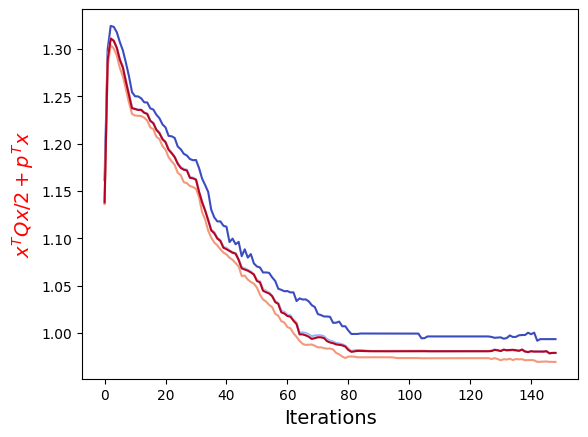

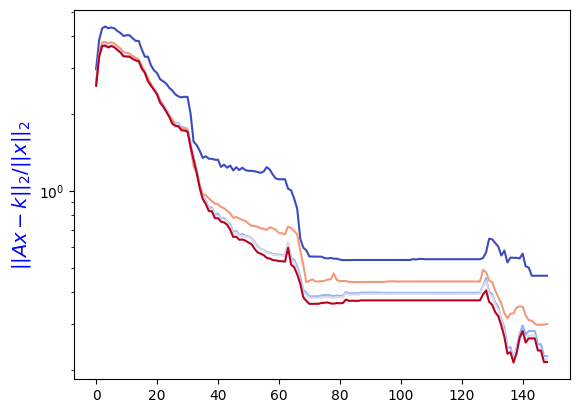

In [20]:
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 5)))

fig, ax = plt.subplots()
ax.plot(normalized_costs)
# ax.plot(np.array([res.info.obj_val]*len(cost)), '-.k')
ax.set_ylabel("$x^T Q x/2 + p^T x $",color="red",fontsize=14)
ax.set_xlabel("Iterations",fontsize=14)

# ax2=ax.twinx()
fig2, ax2 = plt.subplots()
ax2.set_yscale('log')
ax2.plot(normalized_constraint_sats)
ax2.set_ylabel("$||Ax-k||_2 / ||x||_2$",color="blue",fontsize=14)
plt.show()